# Submission Code

In [2]:
# install the required packages first
require(jsonlite)
require(httr)
require(data.table)

get_token <- function(username, password, url_site){
    
    post_body = list(username=username,password=password)
    post_url_string = paste0(url_site,'/token/')
    result = POST(post_url_string, body = post_body)

    # error handling (wrong credentials)
    if(result$status_code==400){
        print('Check your credentials')
        return(0)
    }
    else if (result$status_code==201){
        output = content(result)
        token = output$key
    }

    return(token)
}



send_submission <- function(predictions, token, url_site, submit_now=F){
    
    format_check=check_format(predictions)
    if(!format_check){
        return(FALSE)
    }
    
    post_string="list("
    for(i in 1:length(predictions)){
        if(i<length(predictions)){
            post_string=sprintf("%s%s,",post_string,predictions[i])
        } else {
            post_string=sprintf("%s%s)",post_string,predictions[i])
        }
    }
    
    submission = eval(parse(text=post_string))
    json_body = jsonlite::toJSON(submission, auto_unbox = TRUE)
    submission=list(submission=json_body)
    print(submission)

    if(!submit_now){
        print("You did not submit.")
        return(FALSE)      
    }
    

    header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
    post_url_string = paste0(url_site,'/submission/')
    result = POST(post_url_string, header, body=submission)
    
    if (result$status_code==201){
        print("Successfully submitted. Below you can see the details of your submission")
    } else {
        print("Could not submit. Please check the error message below, contact the assistant if needed.")
    }
    
    print(content(result))
    
}

check_format <- function(predictions){
    
    if(all(is.numeric(predictions)) & all(predictions<=1)){
        print("Format OK")
        return(TRUE)
    } else {
        print("Wrong format")
        return(FALSE)
    }
    
}

# this part is main code
subm_url = 'http://46.101.121.83'

u_name = "Miners"
p_word = "NsY7hhlU9zjl8DH3"
submit_now = TRUE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
# this part is where you need to provide your prediction method/function or set of R codes


# Model

In [38]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(Information)
library(FactoMineR)
library(caTools)

In [39]:
TrainData<-read.csv("IE582_Fall20_ProjectTrain.csv")

TrainData<-TrainData[,-c(50,52)]

In [40]:
TrainData=as.data.table(TrainData)

In [47]:
set.seed(35)
ind_a=sample(1:1565, 400, replace=FALSE)
ind_b=sample(1:509, 400, replace=FALSE)

In [59]:
dt_new_sub_a=TrainData[TrainData[,y=="a"]][ind_a]
dt_new_sub_b=TrainData[TrainData[,y=="b"]][ind_b]

In [60]:
dt_new_sub_a_test=TrainData[TrainData[,y=="a"]][!ind_a]
dt_new_sub_b_test=TrainData[TrainData[,y=="b"]][!ind_b]

In [61]:
dt_new_train=rbind(dt_new_sub,dt_new_sub_b)
dt_new_test=rbind(dt_new_sub_a_test,dt_new_sub_b_test)

In [65]:
set.seed(150)
spl=sample.split(dt_new_train$y, SplitRatio = 0.8)
train=subset(dt_new_train,spl==TRUE)
test=subset(dt_new_train,spl==FALSE)
str(train)

Classes 'data.table' and 'data.frame':	727 obs. of  59 variables:
 $ x1 : int  38 30 33 30 29 33 33 36 26 29 ...
 $ x2 : int  0 1 1 1 1 1 1 1 0 1 ...
 $ x3 : int  1 1 0 0 1 0 1 1 1 0 ...
 $ x4 : int  0 1 0 1 0 1 1 1 1 1 ...
 $ x5 : int  5 11 10 7 7 17 13 14 15 13 ...
 $ x6 : int  10 12 4 17 12 6 18 2 4 13 ...
 $ x7 : int  12 1 2 15 0 17 11 11 18 15 ...
 $ x8 : int  28 40 41 34 25 42 26 29 22 29 ...
 $ x9 : num  101.1 68.6 77.9 114.9 184.9 ...
 $ x10: num  173 113 115 144 102 ...
 $ x11: num  41.6 160.2 132.1 166.2 79.2 ...
 $ x12: int  0 0 0 1 1 0 1 0 0 0 ...
 $ x13: int  1 0 0 0 0 0 0 1 0 0 ...
 $ x14: int  404 404 555 404 404 252 404 404 404 353 ...
 $ x15: int  0 1 1 1 1 0 1 0 1 1 ...
 $ x16: int  0 0 1 0 0 0 0 0 0 0 ...
 $ x17: int  0 0 0 1 0 0 0 1 1 0 ...
 $ x18: int  0 0 0 0 0 0 0 0 0 0 ...
 $ x19: int  0 0 0 0 0 0 0 0 0 0 ...
 $ x20: int  0 0 0 0 1 0 0 0 0 0 ...
 $ x21: int  0 0 0 0 0 0 0 0 0 0 ...
 $ x22: int  0 0 0 0 0 0 0 0 0 0 ...
 $ x23: int  1 1 0 0 1 0 1 0 0 0 ...
 $ x24:

### Performance Function

In [66]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

# Prediction & Control with Train Dataset

In [68]:
library(caret)
library(e1071)

In [69]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10)

In [77]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*10, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli"

"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, mis

Stochastic Gradient Boosting 

909 samples
 58 predictor
  2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 818, 818, 818, 818, 819, 818, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.1        1                  10       0.7514286  0.5039484
  0.1        1                  20       0.7657265  0.5288199
  0.1        1                  30       0.7734432  0.5434186
  0.1        1                  40       0.7800855  0.5532491
  0.1        1                  50       0.7745543  0.5415462
  0.1        3                  10       0.7745543  0.5391552
  0.1        3                  20       0.8009524  0.5966137
  0.1        3                  30       0.7998535  0.5945626
  0.1        3                  40       0.7899389  0.5743712
  0.1        3                  50       0.7899756  0.5742196
  0.1        5                  10       0.7701709  0.53

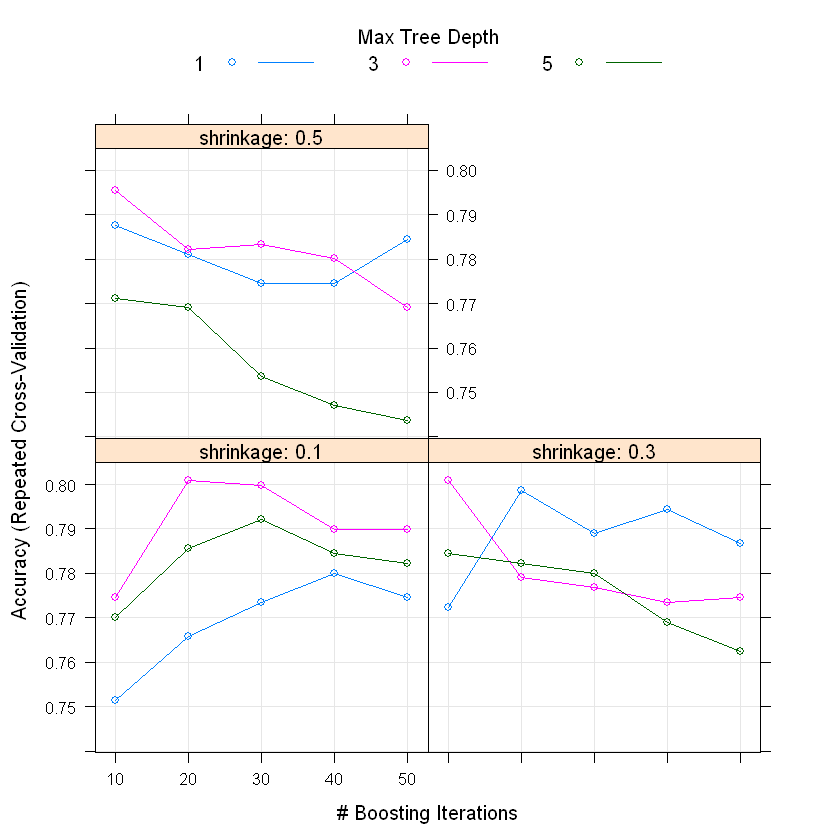

In [78]:
gbm_fit=train(y ~ ., data = dt_new, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F)

gbm_fit
plot(gbm_fit)

In [79]:
predictions_train=predict(gbm_fit,test)

In [80]:
confusionMatrix(data = as.factor(predictions_train), reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction  a  b
         a 83 18
         b 19 62
                                          
               Accuracy : 0.7967          
                 95% CI : (0.7308, 0.8526)
    No Information Rate : 0.5604          
    P-Value [Acc > NIR] : 1.866e-11       
                                          
                  Kappa : 0.5879          
                                          
 Mcnemar's Test P-Value : 1               
                                          
              Precision : 0.8218          
                 Recall : 0.8137          
                     F1 : 0.8177          
             Prevalence : 0.5604          
         Detection Rate : 0.4560          
   Detection Prevalence : 0.5549          
      Balanced Accuracy : 0.7944          
                                          
       'Positive' Class : a               
                                          

In [74]:
perf_dt("Performance Measure", as.numeric(predictions_train), as.numeric(test$y))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Performance Measure,182,1.467033,0.5002883,0.01872659,0.1373626,0.03250593,0.1923077,0.1310861


In [75]:
table(test$y,predictions_train)

   predictions_train
     a  b
  a 82 20
  b 15 65

# Final Model

In [85]:
final_test=read.csv("IE582_Fall20_ProjectTest.csv")

final_test<-final_test[,-c(50,52)]

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli"

"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 37: x37 has no variation."Warning message in (function (x, y, offset = NULL, mis

Stochastic Gradient Boosting 

909 samples
 58 predictor
  2 classes: 'a', 'b' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 818, 818, 819, 818, 818, 818, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  Accuracy   Kappa    
  0.1        1                  10       0.7316361  0.4613310
  0.1        1                  20       0.7580098  0.5172958
  0.1        1                  30       0.7634066  0.5200958
  0.1        1                  40       0.7854945  0.5646225
  0.1        1                  50       0.7777656  0.5475059
  0.1        3                  10       0.7667643  0.5227149
  0.1        3                  20       0.7865934  0.5665408
  0.1        3                  30       0.7931624  0.5794174
  0.1        3                  40       0.7975824  0.5887340
  0.1        3                  50       0.7876801  0.5682422
  0.1        5                  10       0.7678632  0.52

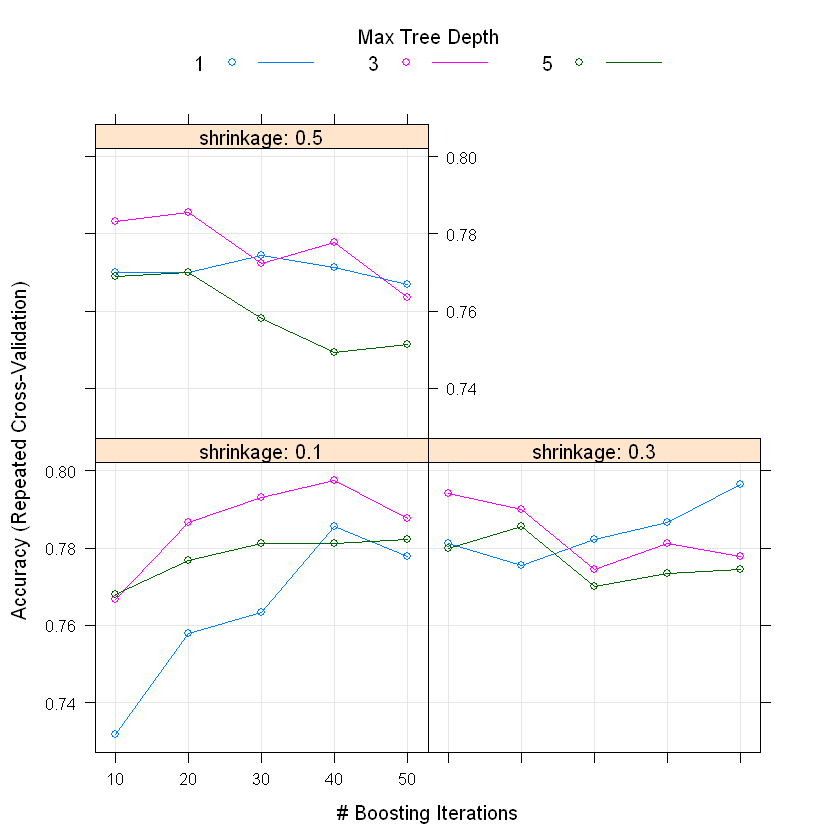

In [86]:
gbm_fit=train(y ~ ., data = dt_new_train, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F)

gbm_fit
plot(gbm_fit)

In [44]:
predictions=predict(gbm_fit,final_test)

In [45]:
final_prediction=as.numeric(predictions)-1

# Random Forest

In [81]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



In [83]:
random_forest=randomForest(as.factor(y)~.,data=train,ntree=500,nodesize=20)
random_forest


Call:
 randomForest(formula = as.factor(y) ~ ., data = train, ntree = 500,      nodesize = 20) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 20.08%
Confusion matrix:
    a   b class.error
a 335  72   0.1769042
b  74 246   0.2312500

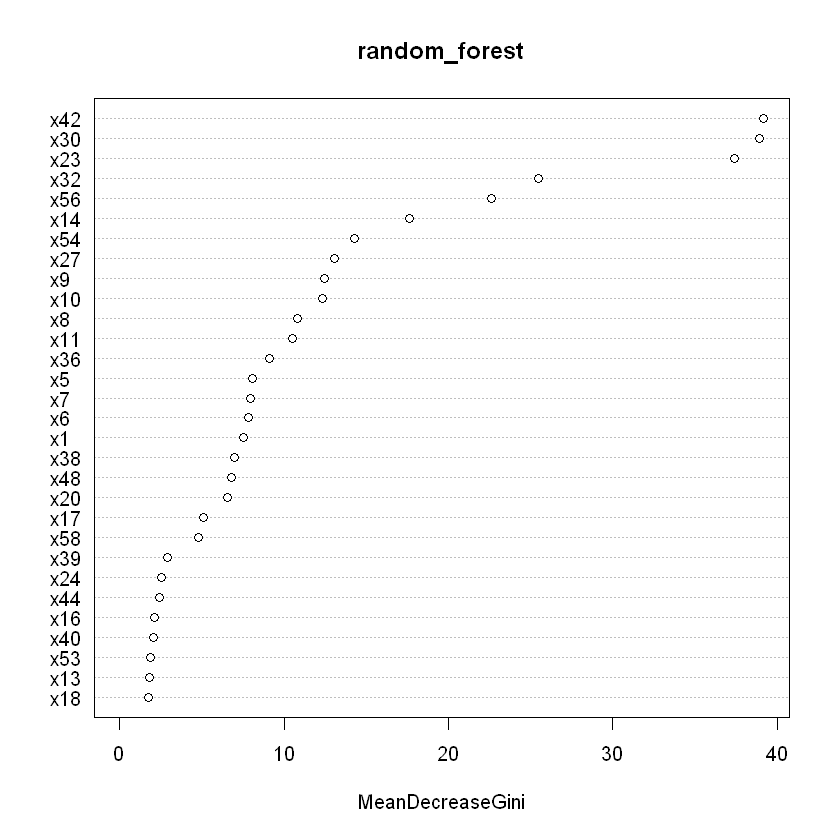

In [48]:
varImpPlot(random_forest)

In [84]:
PredictRandomForest=predict(random_forest,newdata=test)
table(test$y,PredictRandomForest)

   PredictRandomForest
     a  b
  a 80 22
  b 20 60

In [50]:
confusionMatrix(data = PredictRandomForest, reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   a   b
         a 300  51
         b  13  51
                                          
               Accuracy : 0.8458          
                 95% CI : (0.8074, 0.8792)
    No Information Rate : 0.7542          
    P-Value [Acc > NIR] : 3.672e-06       
                                          
                  Kappa : 0.5243          
                                          
 Mcnemar's Test P-Value : 3.746e-06       
                                          
              Precision : 0.8547          
                 Recall : 0.9585          
                     F1 : 0.9036          
             Prevalence : 0.7542          
         Detection Rate : 0.7229          
   Detection Prevalence : 0.8458          
      Balanced Accuracy : 0.7292          
                                          
       'Positive' Class : a               
                                          

In [51]:
perf_dt("Random Forest",as.numeric(test$y),as.numeric(PredictRandomForest))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Random Forest,415,1.245783,0.4310702,0.07350097,0.09277108,0.01927711,0.1542169,0.1237911


In [52]:
random_forest_final=randomForest(as.factor(y)~.,data=TrainData,ntree=500,nodesize=20)
random_forest_final


Call:
 randomForest(formula = as.factor(y) ~ ., data = TrainData, ntree = 500,      nodesize = 20) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 15.53%
Confusion matrix:
     a   b class.error
a 1489  76   0.0485623
b  246 263   0.4833006

In [53]:
predictions_rf=predict(random_forest_final,final_test)
predictions_rf_final=as.numeric(predictions_rf)-1

In [54]:
table(final_prediction,predictions_rf_final)

                predictions_rf_final
final_prediction    0    1
               0 1665   29
               1   49  330

# Penalized Version

In [55]:
library(rpart)
library(GGally, quietly=TRUE)
library(rattle)

In [56]:
PenaltyMatrix = matrix(c(0,1.5,5,0), byrow=TRUE, nrow=2)
PenaltyMatrix

0,1.5
5,0.0


x23         x56         x54         x17         x44         x32 
218.5796985 194.0170808 125.8489173  90.7988899  76.4476976  66.8660441 
        x14         x42         x10         x58         x36         x27 
 43.7771114  15.5868168   5.9659727   1.7018881   1.0167878   0.9283026 
        x30          x1         x16          x7          x5         x33 
  0.7625908   0.6883815   0.6883815   0.6883815   0.5736512   0.5083939 
         x9         x22          x8 
  0.4641513   0.3094342   0.2541969

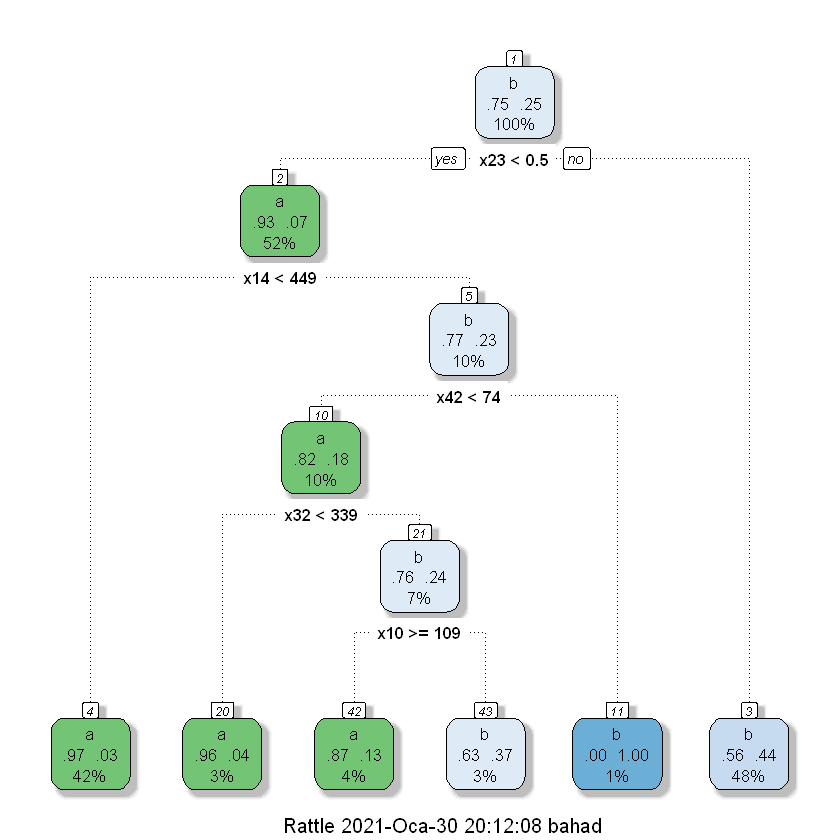

In [57]:
DecTree_pen = rpart(y ~ .,
                   data=train, method="class", parms=list(loss=PenaltyMatrix),
                   cp=0.01)
fancyRpartPlot(DecTree_pen)
DecTree_pen$variable.importance

In [58]:
penalized_tree=predict(DecTree_pen,newdata=test,type="class")
table(test$y,penalized_tree)

   penalized_tree
      a   b
  a 180 133
  b  11  91

In [59]:
confusionMatrix(data = penalized_tree, reference = as.factor(test$y), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction   a   b
         a 180  11
         b 133  91
                                         
               Accuracy : 0.653          
                 95% CI : (0.605, 0.6988)
    No Information Rate : 0.7542         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.333          
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
              Precision : 0.9424         
                 Recall : 0.5751         
                     F1 : 0.7143         
             Prevalence : 0.7542         
         Detection Rate : 0.4337         
   Detection Prevalence : 0.4602         
      Balanced Accuracy : 0.7336         
                                         
       'Positive' Class : a              
                                         

### Performanca Measure

In [60]:
DecTree_pen = rpart(y ~ .,
                   data=TrainData, method="class", parms=list(loss=PenaltyMatrix),
                   cp=0.01)

In [61]:
penalized_tree_final=predict(DecTree_pen,newdata=final_test,type="class")
penalized_tree_fin_nm=as.numeric(penalized_tree_final)-1

In [62]:
length(penalized_tree_fin_nm)

[1] 2073

# General Table

## Training

In [63]:
table(test$y)


  a   b 
313 102 

In [64]:
table(test$y,predictions_train,penalized_tree)

, , penalized_tree = a

   predictions_train
      a   b
  a 180   0
  b  11   0

, , penalized_tree = b

   predictions_train
      a   b
  a 119  14
  b  36  55


In [65]:
table(test$y,PredictRandomForest,penalized_tree)

, , penalized_tree = a

   PredictRandomForest
      a   b
  a 180   0
  b  11   0

, , penalized_tree = b

   PredictRandomForest
      a   b
  a 120  13
  b  40  51


In [66]:
y_num=as.numeric(test$y)-1
rf_num=as.numeric(PredictRandomForest)-1
pr_num=as.numeric(penalized_tree)-1
sb_num=as.numeric(predictions_train)-1

In [67]:
length(test$y)

[1] 415

In [68]:
last_num=array(1:2073)

In [69]:
for(i in 1:length(final_prediction)){
    if(final_prediction[i]==1 | predictions_rf_final[i]==1){
        last_num[i]=1
    }
    else{
        last_num[i]=0
    }
}

In [85]:
head(last_num,60)

[1] 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1
[39] 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0

In [83]:
head(final_prediction,60)

[1] 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1
[39] 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0

In [82]:
head(predictions_rf_final,60)

[1] 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1
[39] 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0

## Test

In [70]:
table(final_prediction,predictions_rf_final,penalized_tree_fin_nm)

, , penalized_tree_fin_nm = 0

                predictions_rf_final
final_prediction    0    1
               0 1306    2
               1   11   18

, , penalized_tree_fin_nm = 1

                predictions_rf_final
final_prediction    0    1
               0  359   27
               1   38  312


# Submission

In [86]:
send_submission(last_num, token, url=subm_url, submit_now= submit_now)

[1] "Format OK"
$submission
[0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0